In [1]:
!pip install keras==2.8.0
!pip install tensorflow==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping,Callback,CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, load_model
from sklearn.tree import DecisionTreeClassifier
from keras.utils.vis_utils import plot_model
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score
from warnings import filterwarnings
from collections import defaultdict
from scipy.special import softmax
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from keras import backend as K
from collections import deque
from typing import Callable
from keras import layers
import tensorflow as tf
from sklearn import svm
from typing import List
import seaborn as sns
import pandas as pd
import numpy as np 
import requests
import random
import pickle
import keras
import copy
import json
import sys
import os
import re

sns.set(rc = {'figure.figsize':(22,12)}, style="whitegrid")
filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
par_path = '/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Hiden'
def FSR_P():return '/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Featuer_selection_results'
def MINFO_P():return '/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Featuer_selection_results'

In [5]:
def creat_callbacks():
  checkpoint = ModelCheckpoint(os.path.join(model_info_path,"Dfs_weights.best.hdf5"), monitor='val_loss', verbose=False, save_best_only=True, mode='min')
  history_logger = CSVLogger(os.path.join(model_info_path,'Dfs_history.csv'), separator=",", append=True)
  es = EarlyStopping(monitor='val_loss', patience=5)
  callbacks_list = [GarbageCollectorCallback(),checkpoint, es,history_logger]
  return callbacks_list

In [6]:
class GarbageCollectorCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [7]:
from keras import backend as K 
def create_network(shape):
    """
    _INPUT (down) IF WE WANT TO CREAT MODEL WITHOUT FIRST LSTM LAYER  (shape) IF THE PREVIOS PAREMETER IS TRUE WE NEED DIFINE THE SHAPE FOR INPUT LAYER
    _OUTPUT THE MODEL 
    """
    K.clear_session()
    model = Sequential() 
    model.add(layers.InputLayer(input_shape=shape))
    # model.add(Bidirectional(LSTM(units=50, input_shape=(None, 50), return_sequences=True)))
    # TextCNN with 4 conv layers
    model.add(Conv1D(128, 7, activation='tanh', input_shape=(None, 32)))
    model.add(Conv1D(128, 15, activation='tanh'))
    model.add(Conv1D(128, 25, activation='tanh'))
    model.add(Conv1D(128, 35, activation='tanh'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    # model.load_weights(os.path.join(model_info_path,"Dfs_weights.best.hdf5"))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    # model.summary()
    plot_model(model, to_file=os.path.join(model_info_path,'text_cnn_model.png'), show_shapes=True, show_layer_names=True)
    return model

# 1. Policy Function & DQN Architicture 
* 1- epsilon greedy implementaion for make action
* 2- DQN model and compile

In [8]:
def epsilon_greedy(expected_reward, epsilon=0.97) -> int:
    """
    expected_reward: list of expected rewards for each possible action
    epsilon: .
    """
    if np.random.rand() <= epsilon:
        return np.random.choice(list(range(len(expected_reward))))
    else:
        return np.argmax(expected_reward)

PolicyFunction  = Callable[[np.ndarray, float], int]

In [9]:
LEARNING_RATE = 0.001

def create_model(input_dim):
    K.clear_session()
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(input_dim,)))
    model.add(keras.layers.Dense(32, kernel_initializer='he_uniform', activation='relu'))
    model.add(keras.layers.Dense(16, kernel_initializer='he_uniform', activation='relu'))
    model.add(keras.layers.Dense(2))
    model.compile(loss='mse', optimizer='adam')
    return model

## 2. Agents Implementaion

* Agents class will be the parent of 4 types of agents listed as follow:
    * 1- Softmax version (distrbute the total reward between agents using softmax function)
    * 2- Average version (distrbute the total reward between agents using average function)
    * 1- regression version (calcualte the contrbution of each agent using regression model)
    * 1- Single Agent version (only one agent at a time can make action and get the total reawrd as a result)

In [10]:
class Agents:
    # class variable
    agent_count = 0
    def __init__(self, evaluation_network, buffer_size: int = 800):
        self.evaluation_network = evaluation_network
        self.target_network = copy.deepcopy(self.evaluation_network)
        self.buffer_size = buffer_size
        self.fitted = False
        self.agent_id = Agents.agent_count
        Agents.agent_count += 1
        # reply buffer is a list of tuples each tuples contains the following
        # (St, At, St+1, Rt+1)
        # (Current state, Action was made, New state, Reward)
        self.reply_buffer = deque(maxlen=self.buffer_size)
        self.contrbution = np.random.rand()
    def make_action(self, curr_state: np.ndarray, policy_function: PolicyFunction, epsilon) -> int:
        # q_values represents the expected rewards for each possible action
        if self.fitted:

            q_values = self.evaluation_network.predict(curr_state.reshape(-1, 100)) # Agents.agent_count
            action = policy_function(q_values, epsilon)
        else:
            action = policy_function([0, 1], 1)
        return action
    def update_target_network(self):
        self.target_network = copy.deepcopy(self.evaluation_network)
        return

In [11]:
class AgentsSoftmax(Agents):
    def __init__(self, evaluation_network, buffer_size=800):
        super().__init__(evaluation_network, buffer_size)
    def update_evaluation_network(self, batch_size=32, epochs=5, discount_factor=0.995):
        # select random batch from the reply buffer
        batch = random.sample(self.reply_buffer, batch_size)
        # inintilize some lists to store transition information
        Q1, actions, Q2, rewards = [], [], [], []
        # from each transition extract its values
        for transition in batch:
            Q1.append(transition[0])
            actions.append(transition[1])
            Q2.append(transition[2])
            rewards.append(transition[3])
        # X_train will be the states from
        X_train = np.array(Q1)  # .reshape(-1, Agents.agent_count)
        expected_reward = self.evaluation_network.predict(np.array(Q1)) # .reshape(-1, Agents.agent_count)
        Q2 = self.target_network.predict(np.array(Q2)) # .reshape(-1, Agents.agent_count)
        
        # update expected rewards using biliman equation
        for i, act in enumerate(actions[:-1]):
            expected_reward[i, act] = rewards[i] + (discount_factor * np.argmax(Q2[i]))
        y_train = expected_reward.copy()
        # calculate the change frequency of the agent decision to use it as its contrbution in get total reward
        change_frequency = 0
        for state, next_state, reward, next_reward in zip(X_train[:-1], X_train[1:], rewards[: -1], rewards[1:]):
            # print(state, next_state, reward, next_reward)
            for id in range(len(state)):
              if state[id] != next_state[id]: #) == 1: np.abs(
                  self.contrbution += np.abs(reward - next_reward)
                  change_frequency += 1
        self.contrbution /= change_frequency
        # train the DQN evaluation network.
        self.evaluation_network.fit(X_train, y_train, epochs=epochs, verbose=0)
        self.fitted = True
        return

In [12]:
class AgentsRegression(Agents):
    def __init__(self, evaluation_network, buffer_size=800):
        super().__init__(evaluation_network, buffer_size)
    def update_evaluation_network(self, batch_size=32, epochs=5, discount_factor=0.995):
        # select random batch from the reply buffer
        batch = random.sample(self.reply_buffer, batch_size)
        # inintilize some lists to store transition information
        Q1, actions, Q2, rewards = [], [], [], []
        # from each transition extract its values
        for transition in batch:
            Q1.append(transition[0])
            actions.append(transition[1])
            Q2.append(transition[2])
            rewards.append(transition[3])
        # X_train will be the states from

        X_train = np.array(Q1)  # .reshape(-1, Agents.agent_count)
        expected_reward = self.evaluation_network.predict(np.array(Q1)) # .reshape(-1, Agents.agent_count)
        Q2 = self.target_network.predict(np.array(Q2)) # .reshape(-1, Agents.agent_count)

        # X_train = np.array(Q1).reshape(-1, Agents.agent_count) 
        # expected_reward = self.evaluation_network.predict(np.array(Q1).reshape(-1, Agents.agent_count))
        # Q2 = self.target_network.predict(np.array(Q2).reshape(-1, Agents.agent_count))
        
        # update expected rewards using biliman equation
        for i, act in enumerate(actions[:-1]):
            expected_reward[i, act] = rewards[i] + (discount_factor * np.argmax(Q2[i]))
        y_train = expected_reward.copy()
        # train the DQN evaluation network.
        self.evaluation_network.fit(X_train, y_train, epochs=epochs, verbose=0)
        self.fitted = True
        return

In [13]:
class AgentsAverage(Agents):
    def __init__(self, evaluation_network, buffer_size=800):
        super().__init__(evaluation_network, buffer_size)
    def update_evaluation_network(self, batch_size=32, epochs=5, discount_factor=0.995):
        # select random batch from the reply buffer
        batch = random.sample(self.reply_buffer, batch_size)
        # inintilize some lists to store transition information 
        Q1, actions, Q2, rewards = [], [], [], []
        # from each transition extract its values 
        for transition in batch:
            Q1.append(transition[0])
            actions.append(transition[1])
            Q2.append(transition[2])
            rewards.append(transition[3])
        # X_train will be the states from

        X_train = np.array(Q1)  # .reshape(-1, Agents.agent_count)
        expected_reward = self.evaluation_network.predict(np.array(Q1)) # .reshape(-1, Agents.agent_count)
        Q2 = self.target_network.predict(np.array(Q2)) # .reshape(-1, Agents.agent_count)

        # X_train = np.array(Q1).reshape(-1, Agents.agent_count)
        # expected_reward = self.evaluation_network.predict(np.array(Q1).reshape(-1, Agents.agent_count))
        # Q2 = self.target_network.predict(np.array(Q2).reshape(-1, Agents.agent_count))
        # update expected rewards using biliman equation
        for i, act in enumerate(actions[:-1]):
            expected_reward[i, act] = rewards[i] + (discount_factor * np.argmax(Q2[i]))
        y_train = expected_reward.copy()
        WINDOW_SIZE = 4
        X_train_ = np.zeros((X_train.shape[0] // WINDOW_SIZE, X_train.shape[1]))
        y_train_ = []
        j = 0
        for i in range(0, batch_size, WINDOW_SIZE):
            window_of_states = X_train[i: i + WINDOW_SIZE].sum(axis=0) / WINDOW_SIZE
            window_of_rewards = sum(rewards[i: i + WINDOW_SIZE])
            r = window_of_rewards * window_of_states[self.agent_id]
             # Rounding state 
            X_train_[j, :] = np.around(window_of_states)
            if window_of_states[self.agent_id] == 0:
                if window_of_rewards > 0.6:
                    r = window_of_rewards
                else:
                    r = window_of_rewards / WINDOW_SIZE
            y_train_.append(r)
            j += 1

        X_train = X_train_
        y_train = np.array(y_train_)
        # train the DQN evaluation network.
        self.evaluation_network.fit(X_train, y_train, epochs=epochs, verbose=0)
        self.fitted = True
        return

In [14]:
class AgentsSingle(Agents):
    def __init__(self, evaluation_network, buffer_size=800):
        super().__init__(evaluation_network, buffer_size)
    def update_evaluation_network(self, batch_size=32, epochs=5, discount_factor=0.995):
        # select random batch from the reply buffer
        batch = random.sample(self.reply_buffer, batch_size)
        # inintilize some lists to store transition information
        Q1, actions, Q2, rewards = [], [], [], []
        # from each transition extract its values
        for transition in batch:
            Q1.append(transition[0])
            actions.append(transition[1])
            Q2.append(transition[2])
            rewards.append(transition[3])
        # X_train will be the states from

        X_train = np.array(Q1)  # .reshape(-1, Agents.agent_count)
        expected_reward = self.evaluation_network.predict(np.array(Q1)) # .reshape(-1, Agents.agent_count)
        Q2 = self.target_network.predict(np.array(Q2)) # .reshape(-1, Agents.agent_count)

        # X_train = np.array(Q1).reshape(-1, Agents.agent_count)
        # expected_reward = self.evaluation_network.predict(np.array(Q1).reshape(-1, Agents.agent_count))
        # Q2 = self.target_network.predict(np.array(Q2).reshape(-1, Agents.agent_count))
        # update expected rewards using biliman equation
        for i, act in enumerate(actions[:-1]):
            expected_reward[i, act] = rewards[i] + (discount_factor * np.argmax(Q2[i]))
        y_train = expected_reward.copy()
        # train the DQN evaluation network.
        print
        self.evaluation_network.fit(X_train, y_train, epochs=epochs, verbose=0)
        self.fitted = True
        return

In [15]:
def _replaceitem(x):
    if type(x) is list:
        if x[0]<0.5:
            return 0.0
    else:
        x = float(x)
        if x<0.5:
            return 0.0
    return 1.0

# 3. Reward Calculation Method 
* 1- get accuracy of selected feature using logistic regression model 
* 2- claculate the reward with reward_strategy function using accuracy from last step.

In [16]:
# test set percentage 
TESTSIZE=0.2
def get_reward(X:np.numarray, Y:np.numarray, subset_features:list, y_label:str):
    global TESTSIZE
    # index of selected features
    subset_features = np.where(np.array(subset_features) == 1)[0]
    if subset_features.shape[0] == 0:return 0
    # train test split 
    # print(subset_features.tolist())
    X, Y = X[:,:,subset_features.tolist()], Y
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=TESTSIZE)
    # data normalization.
    # std = StandardScaler()
    # X_train = std.fit_transform(X_train)
    # X_test = std.transform(X_test)

    # classification and model evaluation 
    model = create_network(shape=X_train[0].shape)
    model.fit(X_train, y_train,epochs=10, validation_split=0.20,verbose=0)
    y_pred = model.predict(X_test)
    y_test = list(map(_replaceitem, y_test))
    y_pred = list(map(_replaceitem, y_pred))
    acc = accuracy_score(y_test, y_pred)
    return acc

In [17]:
def reward_strategy(time_step: int, accuracy: float, accuracy_history: list, subset_features: list, error_rate: float,
                    beta: float = 0.99):
    if sum(subset_features) == len(subset_features):
        return -5
    elif accuracy > max(accuracy_history):
        return 0.5
    elif accuracy < max(accuracy_history):
        return -0.1
    else:
        return -1 * (beta * error_rate + ((1 - beta) * (sum(subset_features) / len(subset_features))))

# 4. Some helper function 
* 1- Object to store all information about the result like dataset name, accuracy, precision and etc...
* 2- Telegram api to send the result to a chat room 
* 3- Send result to the chat room 

In [18]:
class Results:
    def __init__(self, method_name, dataset_name, chunk_id, feature_space):
        self.dataset_name = dataset_name
        self.method_name = method_name
        self.chunk_id = chunk_id
        self.feature_space = feature_space
        self.feature_space_size = len(feature_space)
        self.result_information = {}
    
    def set_chunk_id(self, chunk_id: int):
        self.chunk_id = chunk_id
    
    def set_feature_space(self, feature_space: list):
        self.feature_space = feature_space
        self.feature_space_size = len(feature_space)
    
    def add_result(self, model_type:str, result:dict):
        self.result_information[model_type] = result
    
    def save(self, path='feature_selection_results'):
        dataset_name = path+"_"+self.dataset_name.split('/')[-1].split('.')[0]
        file_name = self.method_name + '_' + dataset_name + '_' + '{}'.format(self.chunk_id) + '.pkl'
        PATH = os.path.join(feature_selection_results_path, self.method_name)       
        with open(os.path.join(PATH, file_name), 'wb') as file_:
            pickle.dump(self, file_, pickle.HIGHEST_PROTOCOL)
        return     

# 5. Feature Selection Main Algorithm 
* For each type of agents we need a specific feature selection algorithm with little difference between them.
* Evaluation function using different machine learning model based on selected feature
* Result Visulization

In [19]:
def softmax_distrbution(agents):
    contrbutions = []
    for agent in agents:
      # for i in range(10):
      contrbutions.append(agent.contrbution)
    return softmax(contrbutions)

def random_forest_distrbution(X,Y, num_of_samples=10000):
    TX = []
    Ty = []
    num_of_agents = X.shape[2]
    for i in range(num_of_samples):
        features_space = np.random.choice([0, 1], size=(num_of_agents,)).tolist()
        accuracy = get_reward(X,Y, features_space, 'target')   #################################
        TX.append(features_space)
        Ty.append(accuracy)
    TX = np.array(TX)
    Ty = np.array(Ty)
    rf = RandomForestRegressor(n_estimators=15)
    rf.fit(TX, Ty)
    return rf.feature_importances_.tolist()

In [20]:
def feature_selection(algo_type:str, agents: list, X: np.numarray,Y: np.numarray, y_label: str, NUM_OF_FEATURES, NUM_OF_AGENT, eposide=100):
    """
    """
    epsilon = 0.01
    features_space = []
    contrbutions = []
    if algo_type == 'random_forest':
        contrbutions = random_forest_distrbution(X,Y)
    elif algo_type in ['single_agent', 'average']:
        contrbutions = [1] * NUM_OF_FEATURES
    for i in tqdm(range(eposide)):
        # define the initial space
        features_space = np.random.choice([0, 1], size=(NUM_OF_FEATURES,)).tolist()
        # rewards history 
        rewards = [0]
        # get action of each agent to create new feature space 
        next_feature_space = []
        # contrbution of each agent 
        if algo_type == 'softmax':
            contrbutions = softmax_distrbution(agents)
        for t in range(0, NUM_OF_AGENT):
            # for i in range(10):
            action = agents[t].make_action(np.array(features_space.copy()), epsilon_greedy, epsilon)
            next_feature_space.append(action)
            if algo_type == 'single_agent':
                features_space[t] = action
        # calculate the total accuracy of new state (new feature space) and distrbute it using softmax
        # 1- get the accuracy using machine learning model trained in the current subset feature 
        reward_as_accuracy = get_reward(X,Y, next_feature_space, y_label)
        # 2- using the reward strategy map the accuracy value (reward_as_accuracy) to new reward value (reward_at_time_t)
        reward_at_time_t = reward_strategy(t, reward_as_accuracy, rewards, next_feature_space, 1 - reward_as_accuracy)
        # add the accuray of machine learning model to rewards list to use it in the mapping reward strategy.
        rewards.append(reward_as_accuracy)
        # total reward = reward after mapping 
        total_reward = reward_at_time_t
        # add state and actions to agent buffer reply and the reward which equals to contrbution of the agent*total reward
        transition = []
        for t in range(0, NUM_OF_AGENT):
          # for i in range(10):
          transition.clear()
          # add current state (current feature space)
          feature_space_copy = features_space.copy() 
          transition.append(feature_space_copy)
          # add agent's action to the transition
          action = next_feature_space[t]
          transition.append(action)
          # add new state (new feature space) into transition
          transition.append(next_feature_space)
          # add distrbuted reward to the transition
          transition.append(total_reward * contrbutions[t])
          # add the transition to reply buffer 
          agents[t].reply_buffer.append(transition)
          if len(agents[t].reply_buffer) > 32 and i % 32 == 0:
              agents[t].update_evaluation_network()
        if i % 64 == 0:
            for agent in agents:
                if agent.fitted:
                    agent.update_target_network()
        epsilon = 0.97 * epsilon
    return next_feature_space

In [21]:
sns.set(rc={'figure.figsize':(15,12)})

def print_result(y_pred, y_test , title ,color):

    if len(y_test) < len(y_pred):
        y_pred = y_pred[: len(y_test)]
    elif len(y_test) > len(y_pred):
        y_test = y_test[: len(y_pred)]


    accuracy = accuracy_score(y_pred, y_test)
    classification_rep = classification_report(y_test, y_pred)
    con_matrix = confusion_matrix(y_test, y_pred)
    

    if len(con_matrix)==1:
        if len(con_matrix[0])==1:
            con_matrix = list(con_matrix)
            con_matrix[0] = list(con_matrix[0])
            con_matrix[0].append(0)
            con_matrix = np.array([con_matrix[0],[0,0]])
#     print(con_matrix)

    # ploting confustion matrix
    plt.figure(figsize=(25,15))
    plt.subplot(2,1,1)
    # categories = ['Zero', 'One']
    
    T1 = y_test.count(0) if y_test.count(0)!=0 else 1
    T2 = y_test.count(1) if y_test.count(1)!=0 else 1
    
    group_counts = con_matrix
    group_percentages = np.round(con_matrix / np.array([[T1 , T1],[T2 , T2]]),3)
    
    t = 0.5
    plt.text(x=0.0 , y = 2.6, s =  "confusion_matrix :",fontsize=15)
    plt.text(x=0.0 , y = 3.3-t, s =  "Zero ",fontsize=15)
    plt.text(x=0.0 , y = 3.4-t, s =  "One  ",fontsize=15)
    plt.text(x=0.3 , y = 3.2-t, s =  "Zero",fontsize=15)
    plt.text(x=0.6 , y = 3.2-t, s =  "One",fontsize=15)
    plt.text(x=0.3 , y = 3.3-t, s =  "{}".format(con_matrix[0][0]),fontsize=15)
    plt.text(x=0.6 , y = 3.3-t, s =  "{}".format(con_matrix[0][1]),fontsize=15)
    plt.text(x=0.3 , y = 3.4-t, s =  "{}".format(con_matrix[1][0]),fontsize=15)
    plt.text(x=0.6 , y = 3.4-t, s =  "{}".format(con_matrix[1][1]),fontsize=15)
  
    sns.heatmap(group_percentages,xticklabels=['Zero', 'One'], yticklabels=['Zero', 'One'], annot=True, annot_kws={"size": 16},fmt='g', cmap=color)
    plt.title(title ,  fontsize = 18)
    plt.text(x =0,y = 2.3 , s = "accuracy  score on test : {}".format(accuracy),fontsize=15)    
    plt.text(x=0 , y = 3.9, s =  "classification_report :\n {}".format(classification_rep),fontsize=15)
    
    plt.xlabel("Predicted value")
    plt.ylabel("Real value")
    
    plt.savefig(os.path.join(os.path.join(feature_selection_results_path,'Image'),"{} .png".format(title)))

    plt.show()

In [22]:
def model_evaluation(model,method_name, dataset_name, X_train,y_train,X_test,y_test, selected_features, target_column, chunk_id):
    subset_features = np.where(np.array(selected_features) == 1)[0]
    if subset_features.shape[0] == 0:return 0
    for i,x in enumerate(X_train):
      for j in range(x.shape[1]):
        x[:,j] = x[:,j]*selected_features[j]
      X_train[i] = x

    for i,x in enumerate(X_test):
      for j in range(x.shape[1]):
        x[:,j] = x[:,j]*selected_features[j]
      X_test[i] = x
    # X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=TESTSIZE)
    # results = Results(method_name, dataset_name, chunk_id, subset_features.tolist())
    model.fit(X_train, y_train,epochs=10, validation_split=0.20,verbose=0)
    # model.fit(X_train, y_train,epochs=10, validation_split=0.20,verbose=0,batch_size=100,callbacks=callbacks_list) 

    model.save(os.path.join(model_info_path,"model_with_dfs.h5"))
    y_pred = model.predict(X_test)
    y_test = list(map(_replaceitem, y_test))
    y_pred = list(map(_replaceitem, y_pred))

    # savedModel = model.load_weights('gfgModelWeights')  
    # model.save_weights(os.path.join(model_info_path,'Model_Weights_for_chunk_'+str(chunk_id)))
    save_object(y_pred, "y_pred_aftrer_fetuer_selection_chunk_"+str(chunk_id),path=feature_selection_results_path)
    acc, p, r, f1, auc = accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)
    # results.add_result("result_for_chunk_"+str(chunk_id), {'accuracy': acc, 'precision': p, 'recall': r, 'f1-score': f1, 'AUC': auc})
    print_result(y_pred, y_test , "chunk numer_"+str(chunk_id) ,'Oranges')
    # results.save()

In [23]:
def main(x_train_filenames, algorithm_type,num=0,is_ceated=False):
    # is_ceated = True
    for i,f_name in enumerate(x_train_filenames):
        if is_ceated and  i < num :
          continue
        chunk_id = i
        try :
          X_train = load_object("X_train_hiden_for_chunk_"+str(i),par_path)
          Y_train = load_object("y_train_hiden_for_chunk_"+str(i),par_path).to_numpy()
          X_test = load_object("X_test_hiden_for_chunk_"+str(i),par_path) 
          Y_test = load_object("y_test_hiden_for_chunk_"+str(i),par_path).to_numpy() 
        except:
          break
        if not is_ceated:
          model = create_network(shape=X_train[0].shape)
          is_ceated = True
        else:
          model = load_model(os.path.join(model_info_path,"model_with_dfs.h5"))
        number_of_samples = X_train.shape[0]
        agents = []
        Agents.agent_count = 0
        NUM_OF_FEATURES = X_train.shape[2]
        NUM_OF_AGENT = X_train.shape[2] # int(X_train.shape[2] / 10)
        # if NUM_OF_FEATURES%10!=0:
        #   NUM_OF_AGENT += 1
        for i in range(NUM_OF_AGENT):
            if algorithm_type == 'softmax':
                agents.append(AgentsSoftmax(create_model(NUM_OF_FEATURES)))
            elif algorithm_type == 'average':
                agents.append(AgentsAverage(create_model(NUM_OF_FEATURES)))
            elif algorithm_type == 'single_agent':
                agents.append(AgentsSingle(create_model(NUM_OF_FEATURES)))
            elif algorithm_type == 'random_forest':
                agents.append(AgentsRegression(create_model(NUM_OF_FEATURES)))
        result = feature_selection(algorithm_type, agents,  X_train,Y_train, 'target',NUM_OF_FEATURES,NUM_OF_AGENT)
        save_object(result, "results_of_"+algorithm_type+"_"+str(chunk_id),path=feature_selection_results_path)
        model_evaluation(model,algorithm_type, f_name, X_train,Y_train,X_test,Y_test, result, 'target', chunk_id)

In [24]:
def save_object(obj, filename,path):
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()
def load_object(filename,path):
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object

In [25]:
def convert_hiden_stat_to_csv(hiden):
  dfs = []
  for i in range(hiden.shape[0]):
    df = pd.DataFrame()
    for j in range(hiden[i].shape[1]):
      df[j] = [hiden[i][:,j]]
    dfs.append(df)
  return pd.concat(dfs,ignore_index=True)

In [26]:
filenames = os.listdir(par_path)[::-1]
x_train_filenames = [i[:-4] for i in filenames if i[:7]=='X_train']

In [27]:
# algo = 'softmax'
# print("=============================== "+algo+" ===============================")
# feature_selection_results_path = os.path.join(FSR_P(),algo)
# model_info_path = os.path.join(os.path.join(MINFO_P(),algo),"Model info")
# callbacks_list = creat_callbacks()
# main(x_train_filenames,algo)

In [28]:
# algo = 'average'
# print("=============================== "+algo+" ===============================")
# feature_selection_results_path = os.path.join(FSR_P(),algo)
# model_info_path = os.path.join(os.path.join(MINFO_P(),algo),"Model info")
# # callbacks_list = creat_callbacks()
# main(x_train_filenames,algo,36,is_ceated=True)

=============================== single_agent ===============================


  0%|          | 0/100 [00:00<?, ?it/s]

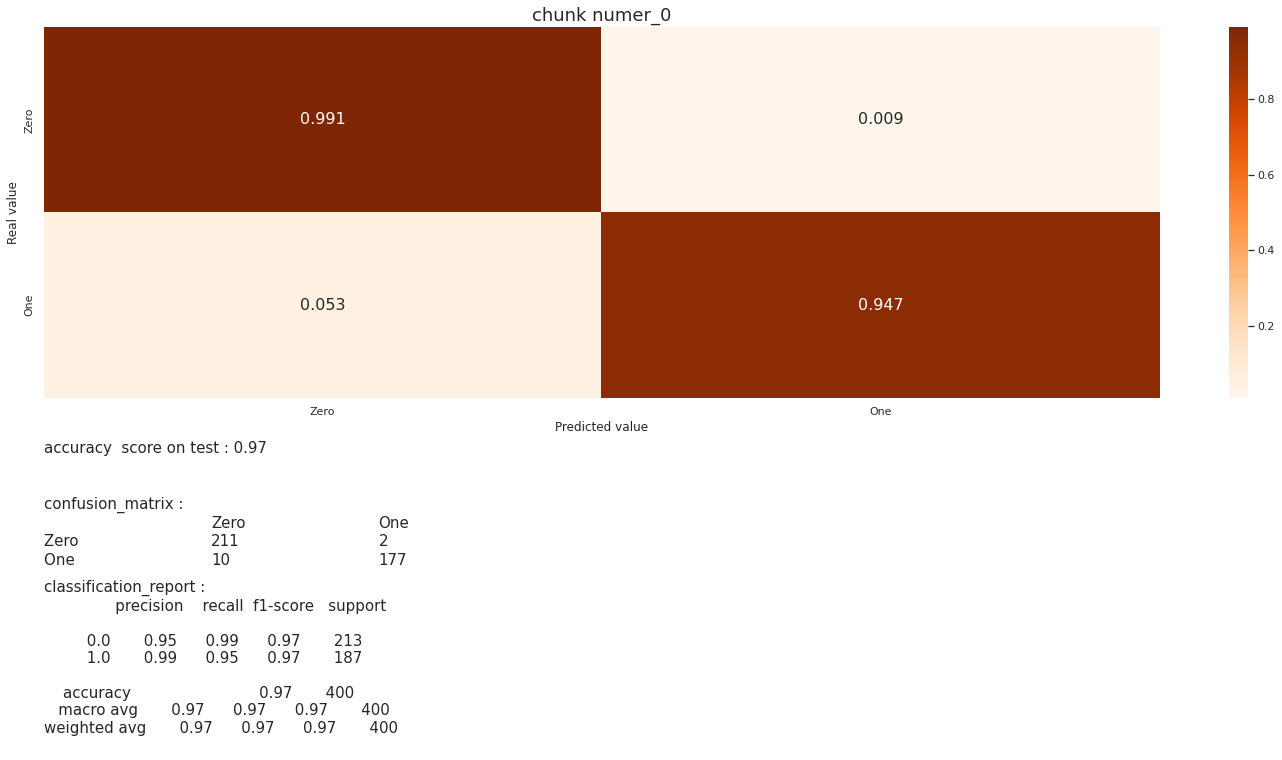

  0%|          | 0/100 [00:00<?, ?it/s]

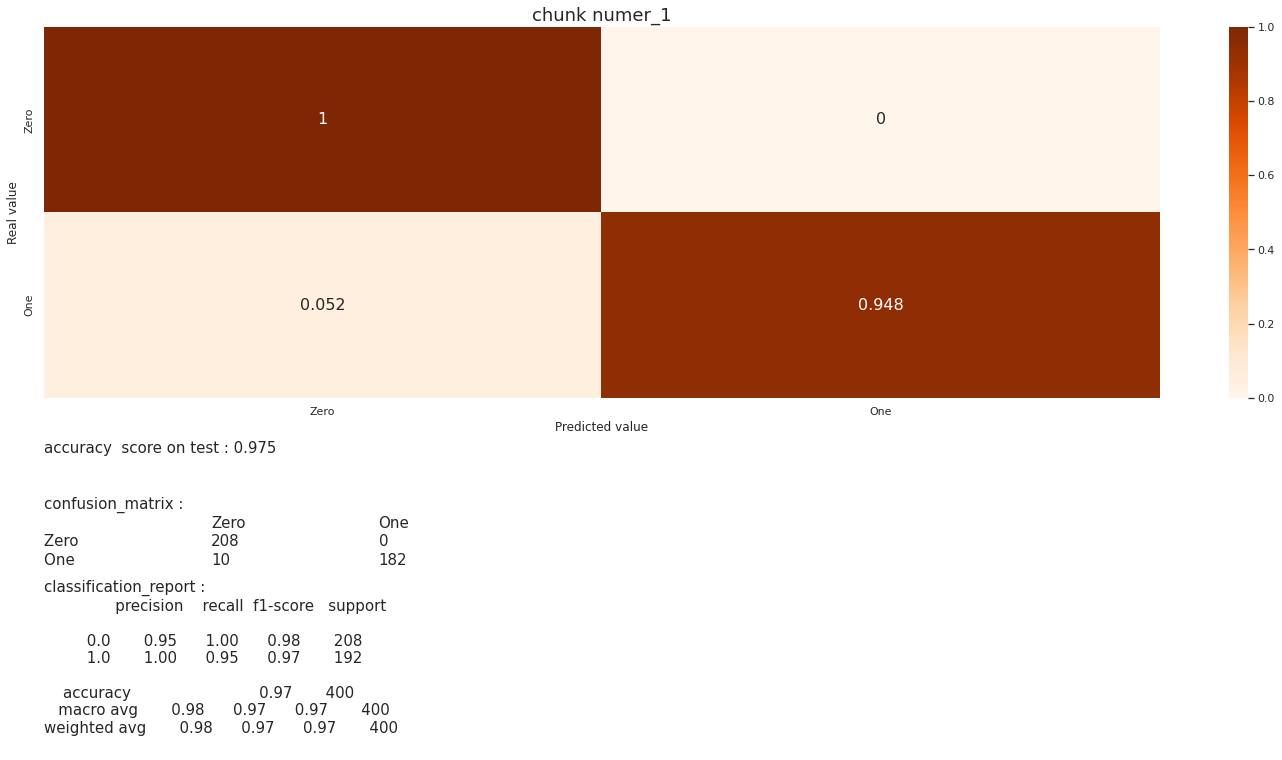

  0%|          | 0/100 [00:00<?, ?it/s]

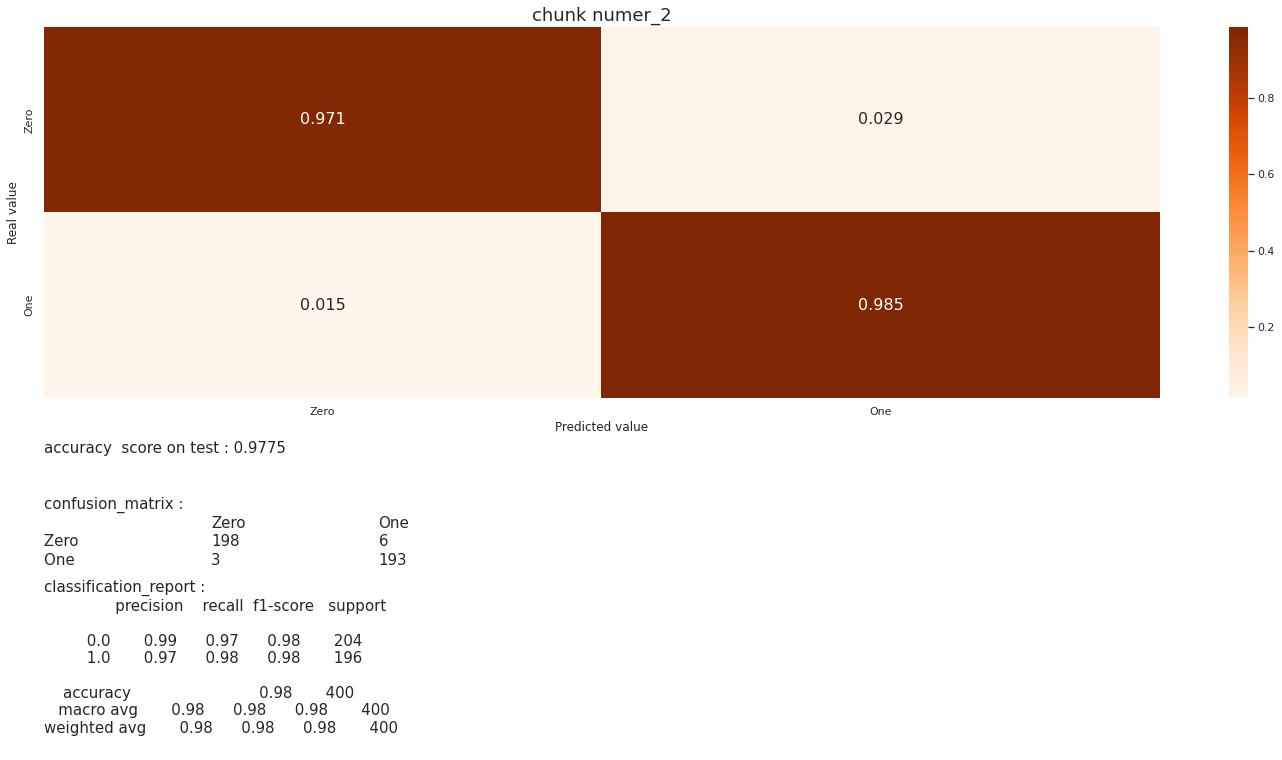

  0%|          | 0/100 [00:00<?, ?it/s]

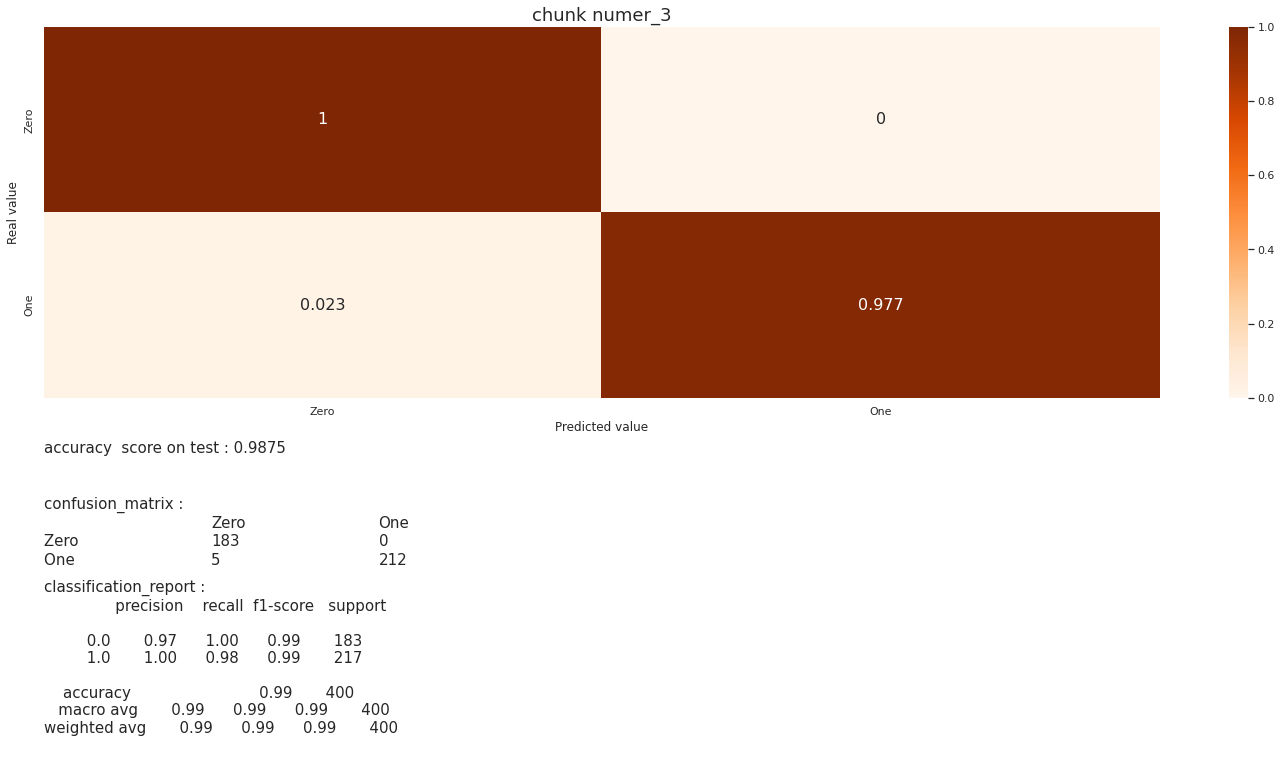

  0%|          | 0/100 [00:00<?, ?it/s]

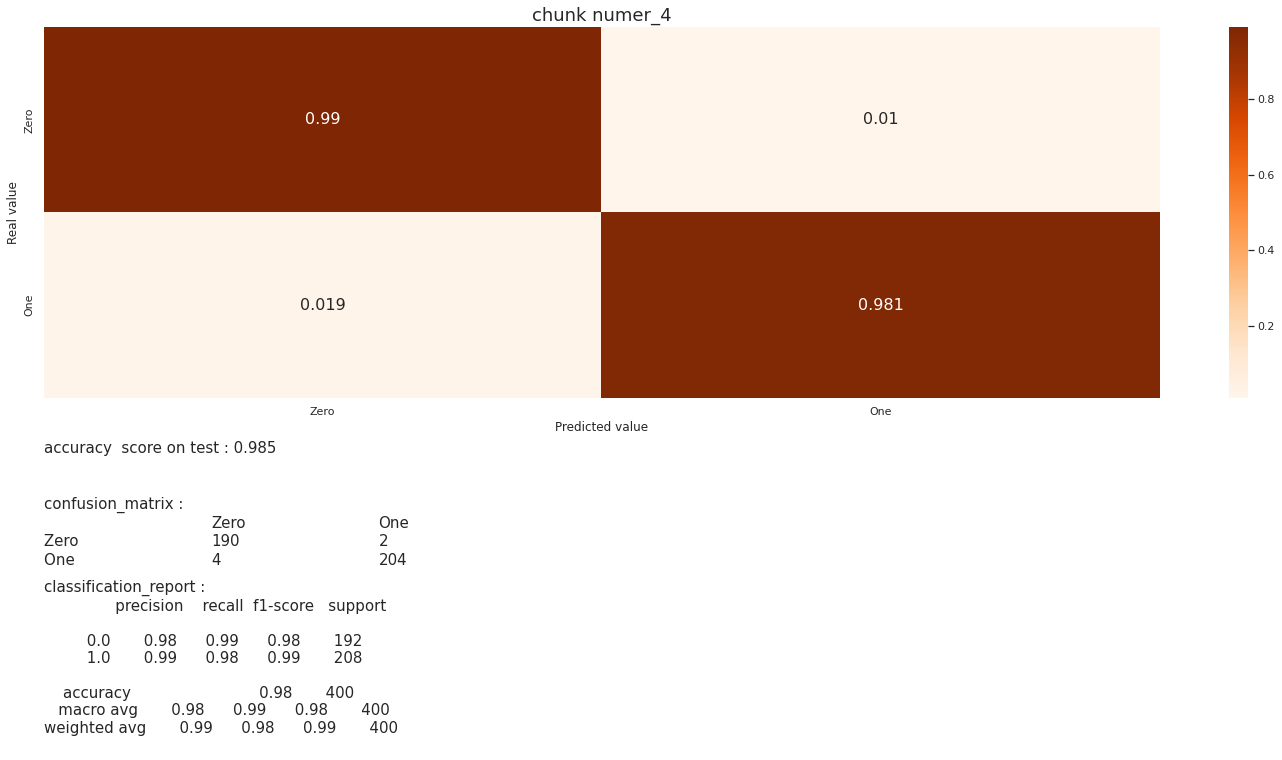

  0%|          | 0/100 [00:00<?, ?it/s]

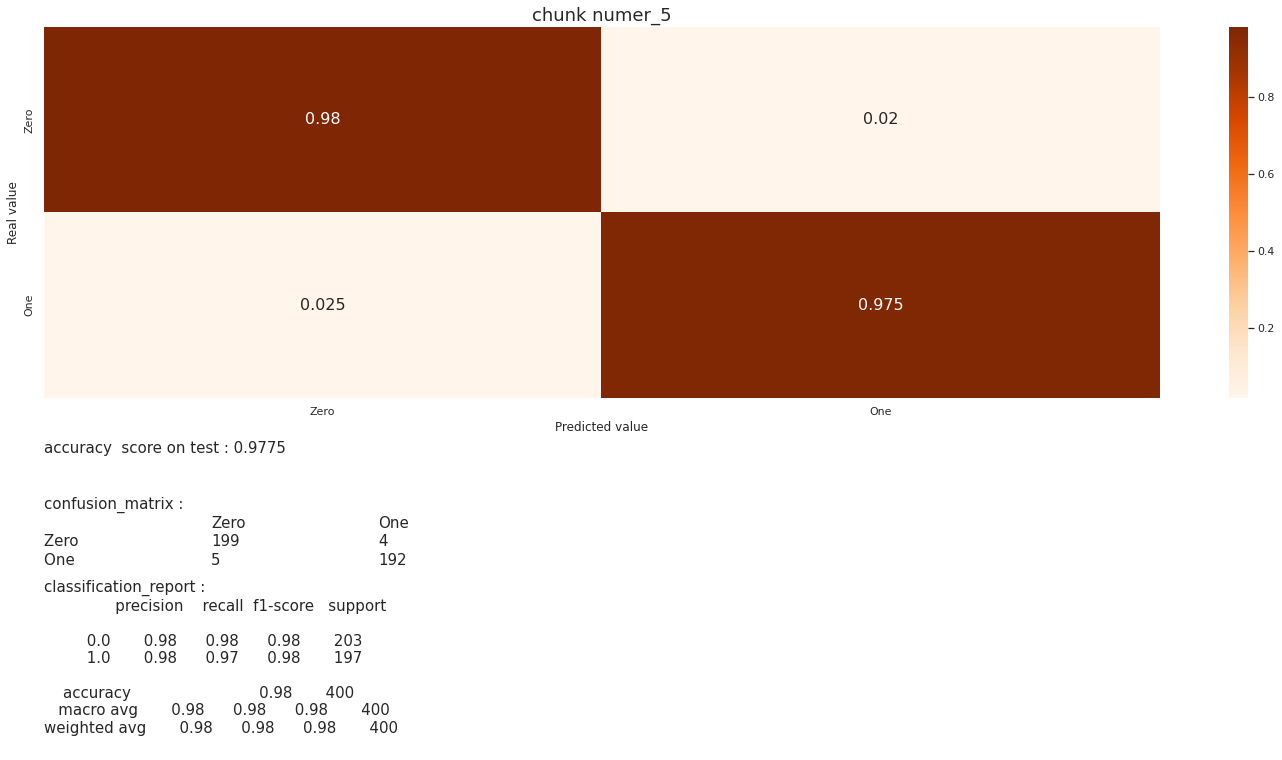

  0%|          | 0/100 [00:00<?, ?it/s]

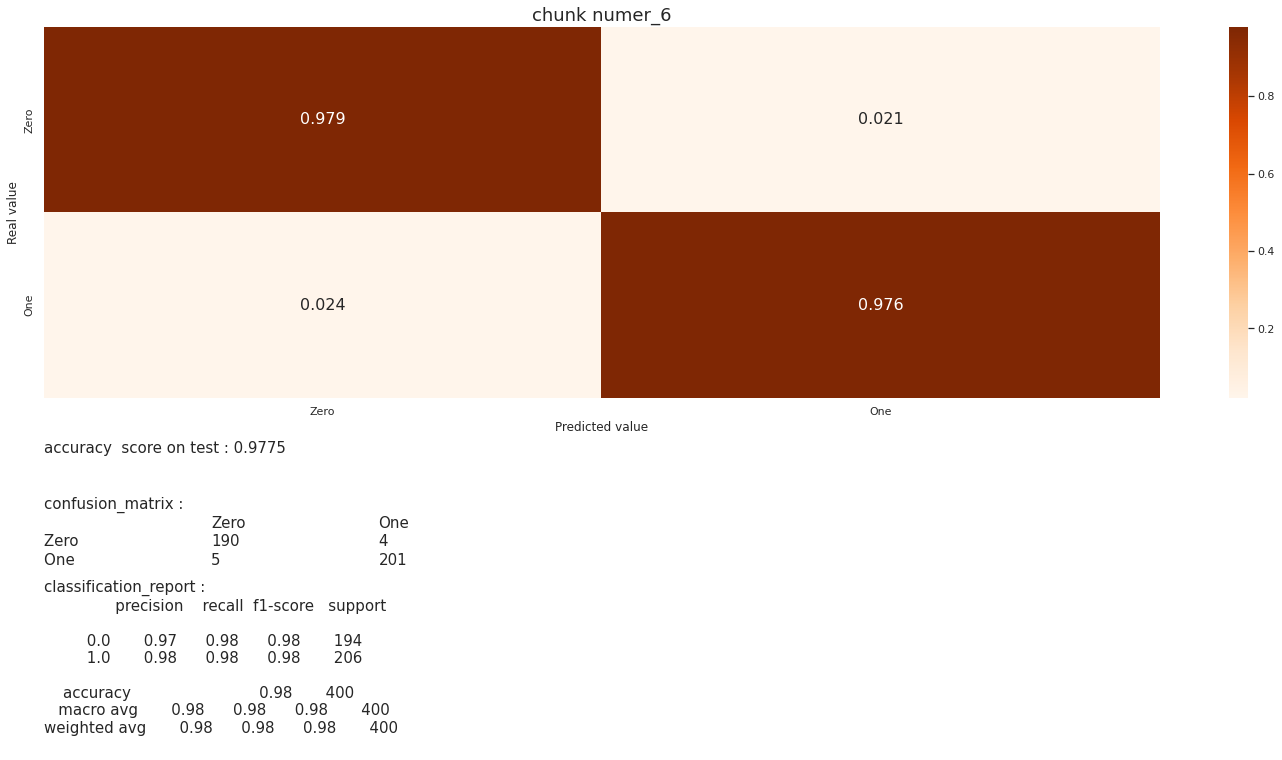

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
algo = 'single_agent'
print("=============================== "+algo+" ===============================")
feature_selection_results_path = os.path.join(FSR_P(),algo)
model_info_path = os.path.join(os.path.join(MINFO_P(),algo),"Model info")
callbacks_list = creat_callbacks()
main(x_train_filenames,algo,num=7,is_ceated=True)

In [ ]:
algo = 'random_forest'
print("=============================== "+algo+" ===============================")
feature_selection_results_path = os.path.join(FSR_P(),algo)
model_info_path = os.path.join(os.path.join(MINFO_P(),algo),"Model info")
# callbacks_list = creat_callbacks()
main(x_train_filenames,algo)